In [ ]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from torchvision.models import vgg19
import torch
from torch import optim
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
from google.colab import drive
import os


In [ ]:
# Define the transformations on the data
low_res_size = 128
high_res_size = 256

transform_low = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((low_res_size, low_res_size)),
    transforms.ToTensor(),
])

transform_high = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((high_res_size, high_res_size)),
    transforms.ToTensor(),
])

In [ ]:
class ImageDataset(Dataset):
    # This is a custom dataset created using pytorch Dataset
    def __init__(self, root_dir):
        super(ImageDataset, self).__init__()
        self.data = []
        self.root_dir = root_dir
        files_low = sorted(os.listdir(os.path.join(root_dir, "low_res")))
        files_high = sorted(os.listdir(os.path.join(root_dir, "high_res")))

        self.data = list(zip(files_low, files_high))


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_low_file, img_high_file = self.data[index]
        # Get the path for the image LR and HR
        low_res_pth = os.path.join(self.root_dir, "low_res", img_low_file)
        high_res_pth = os.path.join(self.root_dir, "high_res", img_high_file)

        # Open the actual image
        low_res = np.array(Image.open(low_res_pth))
        high_res = np.array(Image.open(high_res_pth))

        # Discarding the alpha channel to make the model more optimized for memory
        low_res = low_res[:, :, :3]
        high_res = high_res[:, :, :3]

        # Apply the transformation to the image
        low_res = transform_low(low_res)
        high_res = transform_high(high_res)

        return low_res, high_res

This is the link for the shared dataset folder : https://drive.google.com/drive/folders/17scf9sabn8X72xbNQcy8QlAOZZQ-9vDr?usp=sharing

In [ ]:
def show_image():
    drive.mount('/content/drive')

    # Path to your dataset in Drive
    dataset_path = "/content/drive/My Drive/Dataset/train"

    # Check if the directory exists
    if not os.path.exists(dataset_path):
        print("Error: Dataset path does not exist.")
        return

    # Now you can use the dataset_path variable in your code
    dataset = ImageDataset(root_dir=dataset_path)
    loader = DataLoader(dataset, batch_size=128, num_workers=4)
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    for idx, (low_res, high_res) in enumerate(loader):
        # Display the first image in the left subplot
        axs[0].imshow(low_res[0].permute(1, 2, 0))
        axs[0].set_title("low res")

        # Display the second image in the right subplot
        axs[1].imshow(high_res[0].permute(1, 2, 0))
        axs[1].set_title("high res")

        if(idx == 0):
            break

    # Show the figure
    plt.show()

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


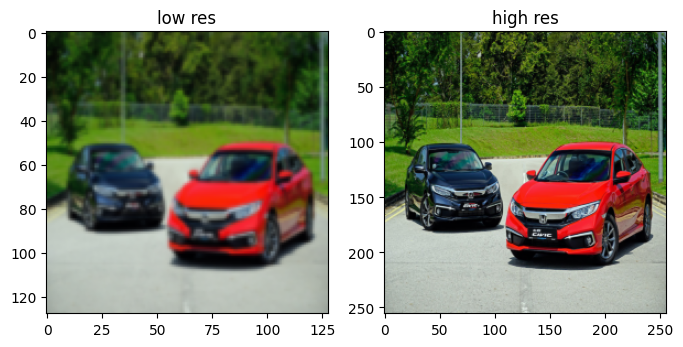

In [ ]:
show_image()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
epochs = 30
batch_size = 16
num_workers = 2
img_channels = 3

In [ ]:

test_vgg_model = vgg19(weights=True).eval().to(device)
lf = list(test_vgg_model.features)
lf[25]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 150MB/s]


Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
class vggL(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:25].eval().to(device)
        self.loss = nn.MSELoss()

    def forward(self, first, second):
        vgg_first = self.vgg(first)
        vgg_second = self.vgg(second)
        perceptual_loss = self.loss(vgg_first, vgg_second)
        return perceptual_loss

In [ ]:
class ConvBlock(nn.Module):
    # Conv -> BN -> leakyReLU
    def __init__(
            self,
            in_channels,
            out_channels,
            use_activation=True,
            use_BatchNorm=True,
            **kwargs
    ):

        super().__init__()
        self.use_activation = use_activation
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels) if use_BatchNorm else nn.Identity()
        self.ac = (
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        x1 = self.cnn(x)
        x2 = self.bn(x1)
        x3 = self.ac(x2)
        return x3 if self.use_activation else x2

In [ ]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * scale_factor ** 2, 2, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)
        self.ac = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        return self.ac(self.ps(self.conv(x)))

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.b1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.b2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_activation=False
        )

    def forward(self, x):
        out = self.b1(x)
        out = self.b2(out)
        return out + x

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=8):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=7, stride=1, padding=4, use_BatchNorm=False)
        self.res = nn.Sequential(*[ResidualBlock(num_channels) for i in range(num_blocks)])
        self.conv = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_activation=False)
        self.up = nn.Sequential(UpsampleBlock(num_channels, scale_factor=2))
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=1)

    def forward(self, x):
        x = self.initial(x)
        c = self.res(x)
        c = self.conv(c) + x
        c = self.up(c)
        return torch.sigmoid(self.final(c))

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride = idx % 2 + 1,
                    padding=1,
                    use_activation=True,
                    use_BatchNorm=idx != 0,
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)

        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten(),
            nn.Linear(512*8*8, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        x = self.blocks(x)
        x = self.mlp(x)
        return x

In [ ]:
def plot_examples(gen):
    dataset_path_g = "/content/drive/My Drive/Dataset/val"
    dataset_test = ImageDataset(root_dir=dataset_path_g)
    loader = DataLoader(dataset_test, batch_size=16, num_workers=2)

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))
    chosen_batch = random.randint(0, len(loader)-1)
    for idx, (low_res, high_res) in enumerate(loader):
        if(chosen_batch == idx):
            chosen = random.randint(0, len(low_res)-1)

            axs[0].set_axis_off()
            axs[0].imshow(low_res[chosen].permute(1, 2, 0))
            axs[0].set_title("low res")

            with torch.no_grad():
                upscaled_img = gen(low_res[chosen].to(device).unsqueeze(0))

            axs[1].set_axis_off()
            axs[1].imshow(upscaled_img.cpu().permute(0, 2, 3, 1)[0])
            axs[1].set_title("predicted")

            axs[2].set_axis_off()
            axs[2].imshow(high_res[chosen].permute(1, 2, 0))
            axs[2].set_title("high res")

            if(idx == 1):
                break

    # Show the figure
    plt.show()

    gen.train()

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def train_progress(epoch, num_epochs, d_losses, g_losses):
    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.title("Training progress")
    plt.plot(d_losses,label="Discriminator loss")
    plt.plot(g_losses,label="Generator loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    print(f"Epoch [{epoch}/{num_epochs}], Discriminator loss: {d_losses[-1]:.4f}, Generator loss: {g_losses[-1]:.4f}")

In [ ]:
# define the generator / discriminator / and other hyperparameters (not already defined above)
gen = Generator(in_channels=3).to(device)
disc = Discriminator(in_channels=3).to(device)
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = vggL()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


In [ ]:
# the data loaders for training and validation
train = ImageDataset(root_dir="/content/drive/My Drive/Dataset/train")
train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers)

val = ImageDataset(root_dir="/content/drive/My Drive/Dataset/val")
val_loader = DataLoader(val, batch_size=batch_size, num_workers=num_workers)

In [ ]:
def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss):
    loop = tqdm(train_loader)
    disc_loss = 0
    gen_loss = 0

    for idx, (low_res, high_res) in enumerate(loop):
        high_res = high_res.to(device)
        low_res = low_res.to(device)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        fake = gen(low_res)

        disc_real = disc(high_res)
        disc_fake = disc(fake.detach())

        disc_loss_real = bce(disc_real, torch.ones_like(disc_real))
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))

        disc_loss = disc_loss_fake + disc_loss_real

        opt_disc.zero_grad()
        disc_loss.backward()
        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        disc_fake = disc(fake)
        adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
        loss_for_vgg = 0.006 * vgg_loss(fake, high_res)
        gen_loss = loss_for_vgg + adversarial_loss

        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()


    return gen_loss.detach().cpu(), disc_loss.detach().cpu()

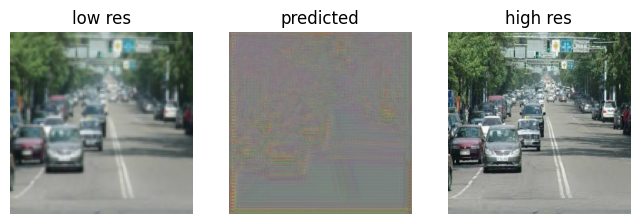

epoch  1 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0162) disc loss: tensor(0.4566)


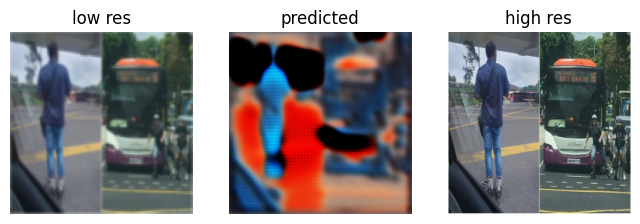

epoch  2 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0125) disc loss: tensor(1.0647)


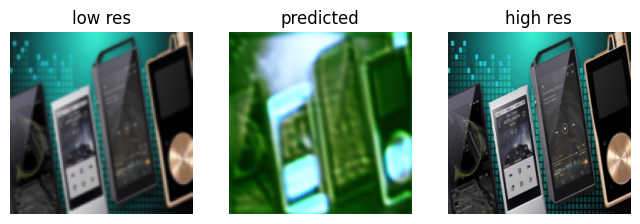

epoch  3 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0104) disc loss: tensor(0.6633)


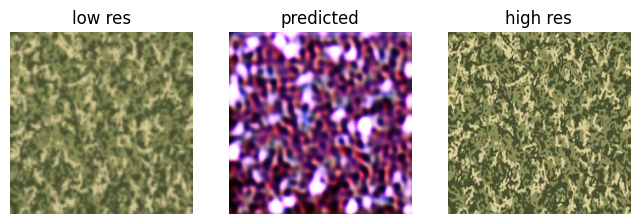

epoch  4 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0116) disc loss: tensor(0.8051)


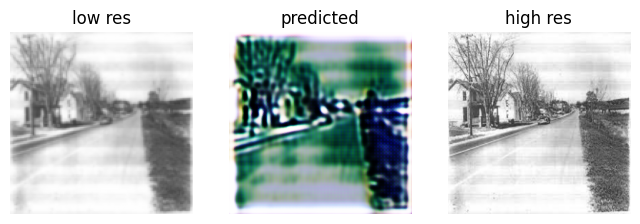

epoch  5 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0097) disc loss: tensor(0.5896)


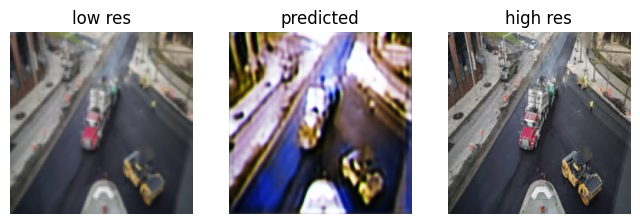

epoch  6 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0126) disc loss: tensor(0.3717)


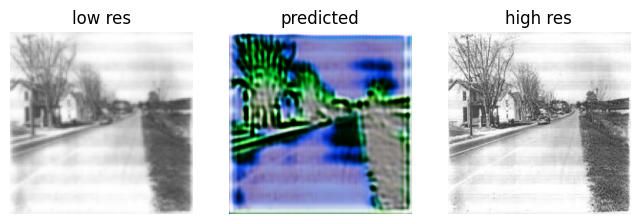

epoch  7 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0077) disc loss: tensor(0.9642)


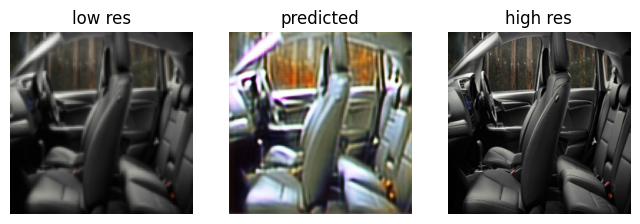

epoch  8 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0111) disc loss: tensor(0.7613)


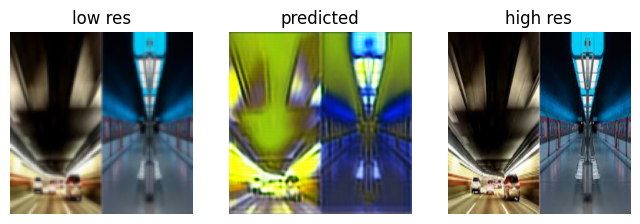

epoch  9 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0073) disc loss: tensor(1.3021)


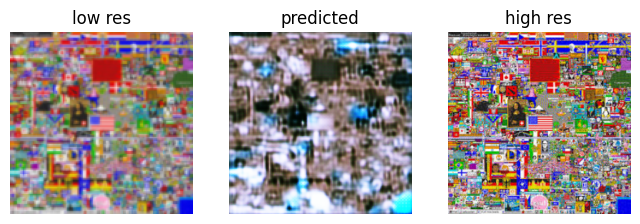

epoch  10 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0063) disc loss: tensor(1.4201)


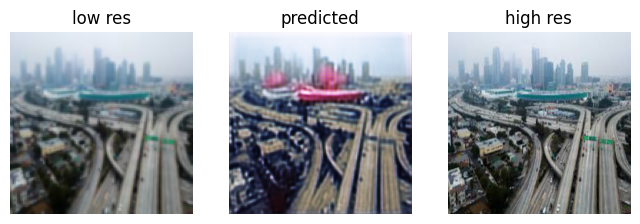

epoch  11 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0057) disc loss: tensor(1.2472)


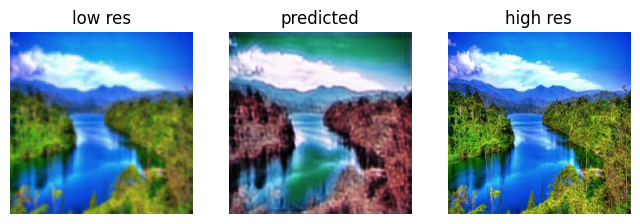

epoch  12 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0064) disc loss: tensor(1.3197)


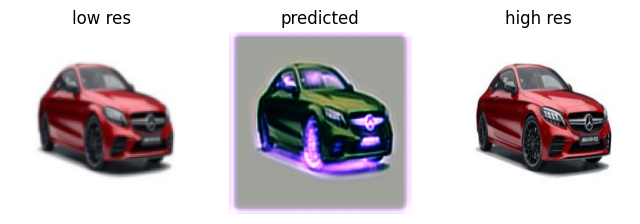

epoch  13 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0079) disc loss: tensor(0.4492)


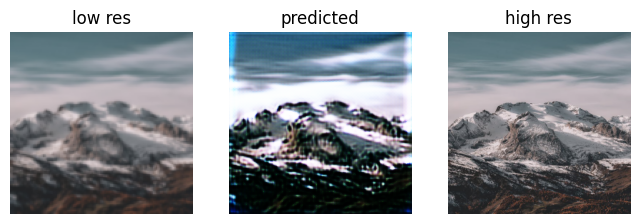

epoch  14 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0065) disc loss: tensor(1.6447)


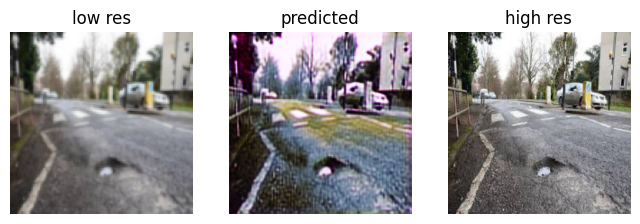

epoch  15 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0067) disc loss: tensor(1.3490)


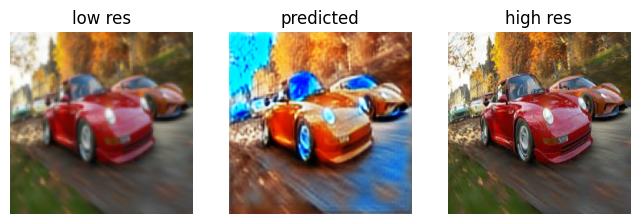

epoch  16 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0052) disc loss: tensor(1.1710)


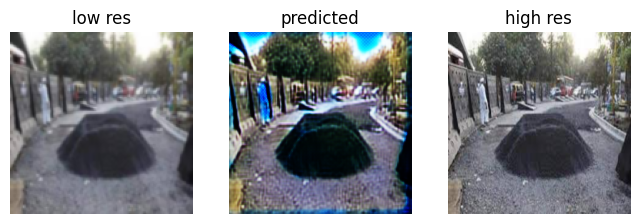

epoch  17 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0043) disc loss: tensor(1.4288)


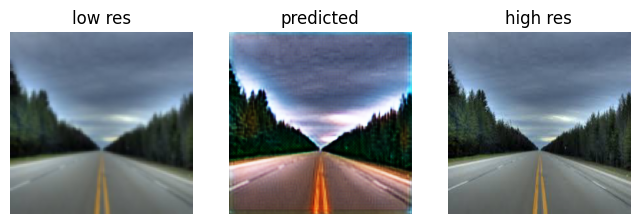

epoch  18 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0041) disc loss: tensor(1.3785)


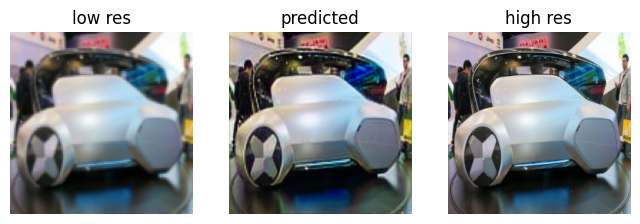

epoch  19 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0063) disc loss: tensor(1.1241)


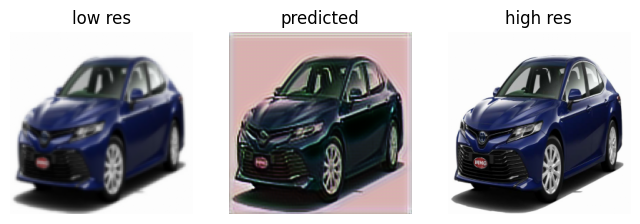

epoch  20 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0043) disc loss: tensor(1.1309)


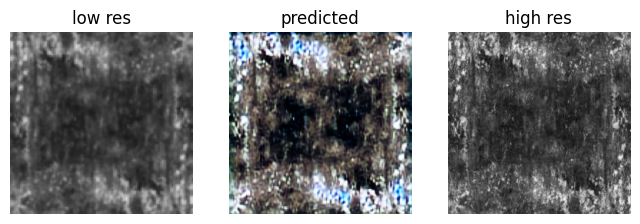

epoch  21 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0041) disc loss: tensor(1.3493)


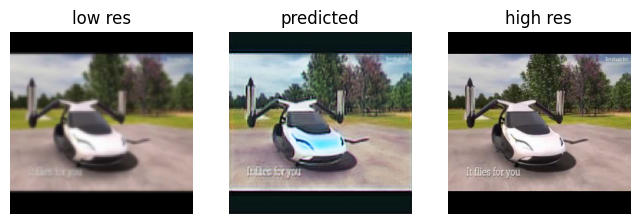

epoch  22 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0043) disc loss: tensor(1.0477)


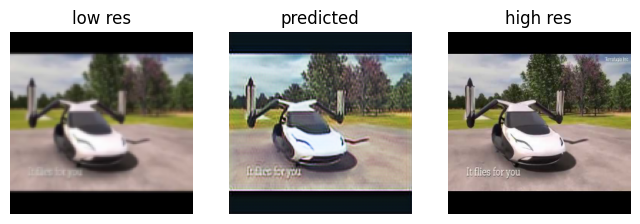

epoch  23 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0035) disc loss: tensor(1.4209)


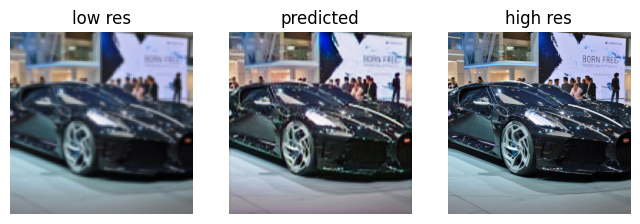

epoch  24 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0033) disc loss: tensor(1.3541)


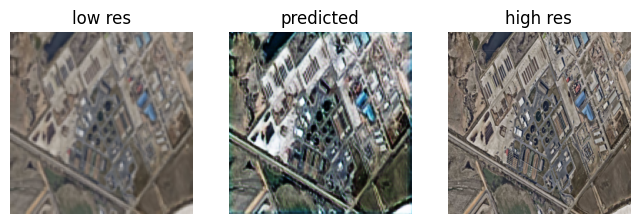

epoch  25 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0039) disc loss: tensor(1.4073)


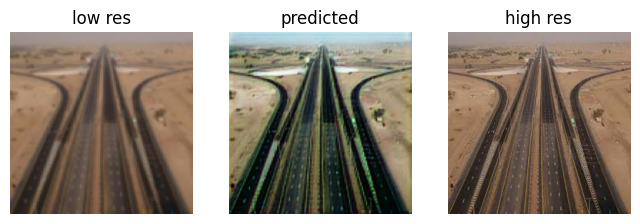

epoch  26 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0038) disc loss: tensor(1.4794)


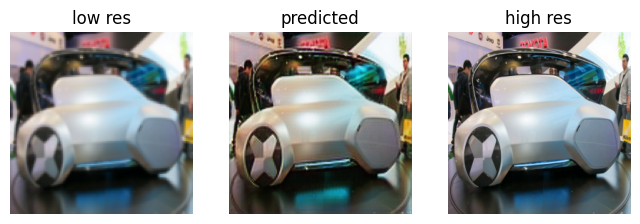

epoch  27 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0035) disc loss: tensor(1.5052)


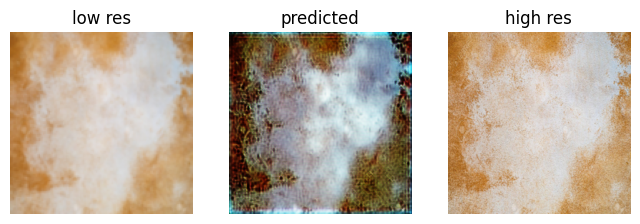

epoch  28 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0031) disc loss: tensor(1.3741)


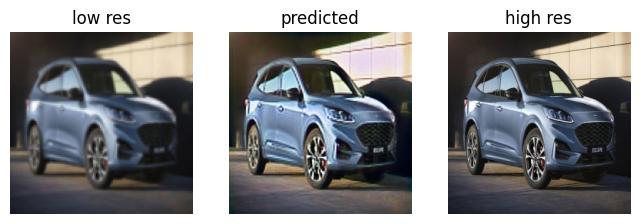

epoch  29 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0034) disc loss: tensor(1.4146)


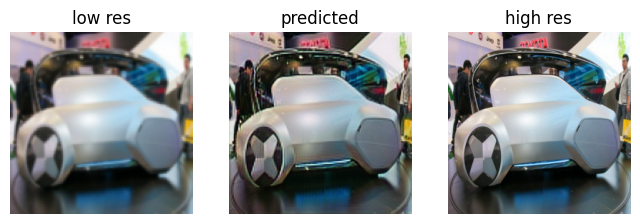

epoch  30 / 30


  0%|          | 0/43 [00:00<?, ?it/s]

genloss: tensor(0.0032) disc loss: tensor(1.3387)


In [ ]:
d_losses = []
g_losses = []
for epoch in range(epochs):
     plot_examples(gen)
     print("epoch ", epoch+1, "/", epochs)
     gen_loss, disc_loss = train_fn(train_loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss)
     # train discriminator and generator and update losses
     d_losses.append(disc_loss)
     g_losses.append(gen_loss)
     print("genloss:",gen_loss,"disc loss:" ,disc_loss)

In [ ]:
print(d_losses)

[tensor(0.4566), tensor(1.0647), tensor(0.6633), tensor(0.8051), tensor(0.5896), tensor(0.3717), tensor(0.9642), tensor(0.7613), tensor(1.3021), tensor(1.4201), tensor(1.2472), tensor(1.3197), tensor(0.4492), tensor(1.6447), tensor(1.3490), tensor(1.1710), tensor(1.4288), tensor(1.3785), tensor(1.1241), tensor(1.1309), tensor(1.3493), tensor(1.0477), tensor(1.4209), tensor(1.3541), tensor(1.4073), tensor(1.4794), tensor(1.5052), tensor(1.3741), tensor(1.4146), tensor(1.3387)]


In [ ]:
print(g_losses)

[tensor(0.0162), tensor(0.0125), tensor(0.0104), tensor(0.0116), tensor(0.0097), tensor(0.0126), tensor(0.0077), tensor(0.0111), tensor(0.0073), tensor(0.0063), tensor(0.0057), tensor(0.0064), tensor(0.0079), tensor(0.0065), tensor(0.0067), tensor(0.0052), tensor(0.0043), tensor(0.0041), tensor(0.0063), tensor(0.0043), tensor(0.0041), tensor(0.0043), tensor(0.0035), tensor(0.0033), tensor(0.0039), tensor(0.0038), tensor(0.0035), tensor(0.0031), tensor(0.0034), tensor(0.0032)]


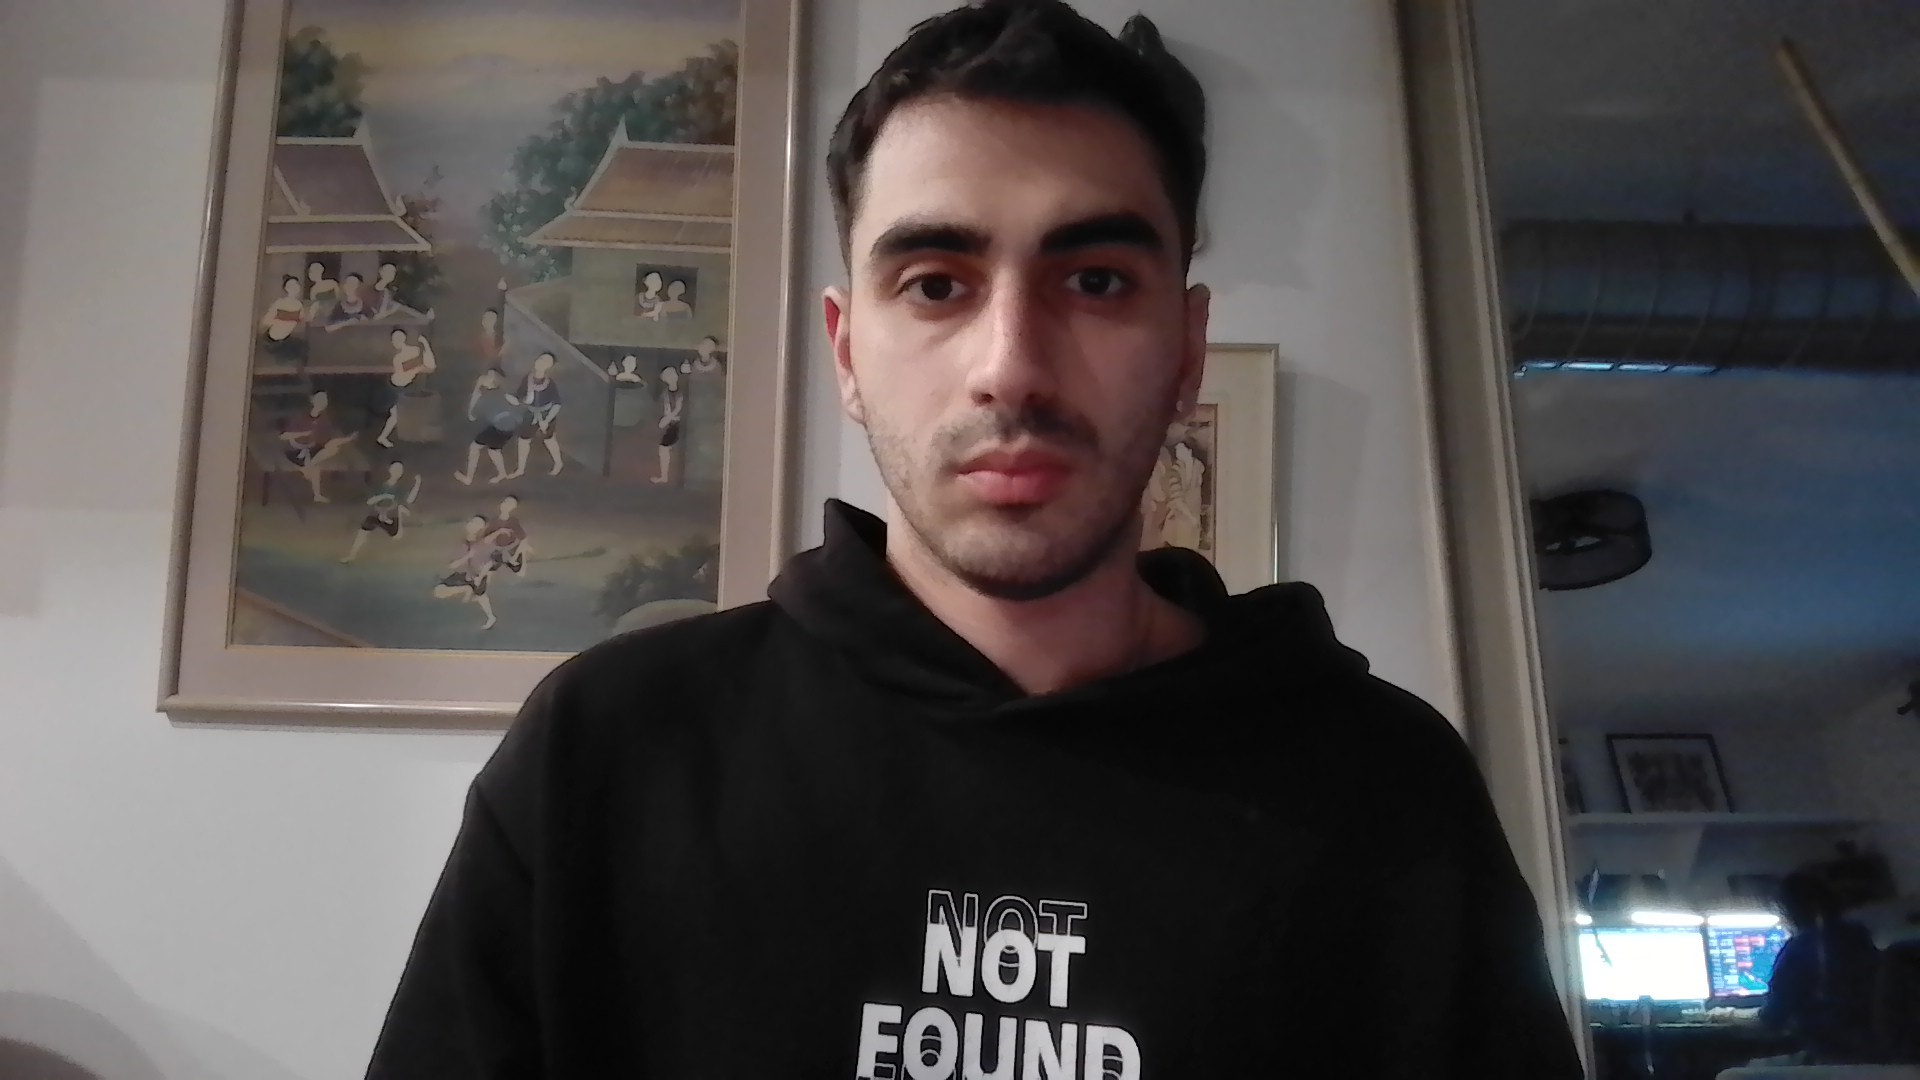

In [ ]:
image_path = '/content/drive/My Drive/test.jpg'
from IPython.display import Image


# Display the image
Image(image_path)

<ipython-input-27-08ac3b4354cd>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  upscaled_img = gen(torch.tensor(low).to(device).unsqueeze(0))


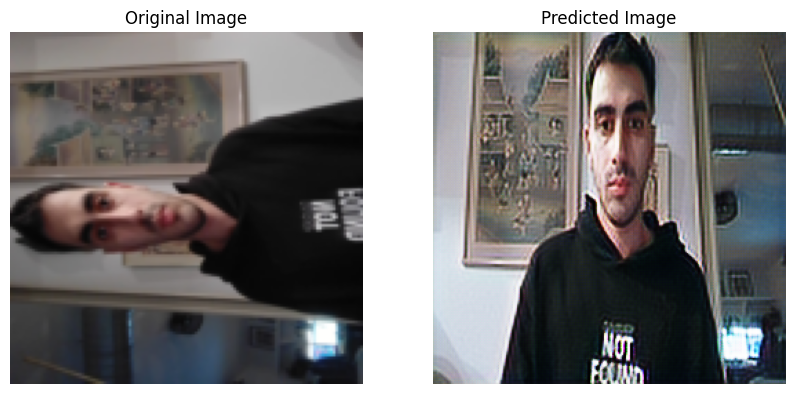

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

low_test = Image.open(image_path)
img_array = np.array(low_test)
low = transform_low(img_array)

with torch.no_grad():
    upscaled_img = gen(torch.tensor(low).to(device).unsqueeze(0))
# Create a figure and an array of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# `axs` is now an array containing two Axes objects, one for each subplot
# The first subplot is accessed using axs[0], and the second subplot with axs[1]

# Example usage:
axs[0].set_axis_off()  # Turn off axes for the first subplot
axs[0].imshow(low.T)  # Display the image in the first subplot
axs[0].set_title("Original Image")  # Set the title for the first subplot

# Similarly, for the second subplot:
axs[1].set_axis_off()
axs[1].imshow(upscaled_img.cpu().squeeze().permute(1, 2, 0))
axs[1].set_title("Predicted Image")

# Finally, display the figure
plt.show()




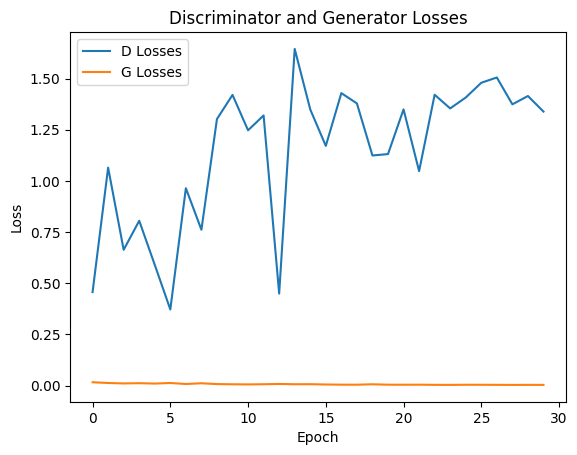

In [ ]:
fig, ax = plt.subplots()

# Plot the data
ax.plot(d_losses, label='D Losses')
ax.plot(g_losses, label='G Losses')

# Add labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Discriminator and Generator Losses')
ax.legend()

# Show the plot
plt.show()